<a href="https://colab.research.google.com/github/ideamanjo/Machine_Learning/blob/master/REINFORCE_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import gym
from gym.wrappers import Monitor
gym_env = "CartPole-v0"
env = gym.envs.make(gym_env)
state = env.reset()
print(env.action_space.n)
print(state)

2
[ 0.04909349 -0.03779625  0.03739267  0.01148315]


In [0]:
use_gpu = torch.cuda.is_available()
print('Use GPU: {}'.format(use_gpu))

Use GPU: True


## Policy Class

In [0]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

## REINFORCE

In [0]:
class REINFORCE:
    def __init__(self):
        self.policy_model = Policy(4, 2, 128)
        self.policy_model = self.policy_model.cuda()
        self.policy_model.train()
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=1e-3)
        
    def select_action(self, state):
        state_tensor = torch.Tensor([state]) # [1 x 4]
        state_tensor = Variable(state_tensor).cuda() # [1 x 4]
        probs = self.policy_model(state_tensor) # [1 x 2]
        probs_cpu = probs.data.cpu()[0] # Tensor cpu [2]
        # Sampling
        if np.random.rand() < probs_cpu[0]:
            action = 0
        else:
            action = 1
        prob = probs[:,action].view(1, -1) # Tensor gpu [1 x 1]
        log_prob = prob.log() # Tensor
        return action, log_prob

    def update_parameters(self, rewards, log_probs, gamma):
        R = 0
        policy_loss = []
        for i in reversed(range(len(rewards))):
            R = rewards[i] + gamma * R
            policy_loss.append(-log_probs[i] * R)
        policy_loss = torch.cat(policy_loss).sum()
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

## Start Training

In [0]:
env = gym.envs.make(gym_env)

epi_rewards = []
max_episode = 1000
max_steps = 1000
gamma = 0.99

env = Monitor(env, './video', force=True, video_callable=lambda episode_id: episode_id == (max_episode -1) )
agent = REINFORCE()
for i_episode in range(max_episode):
    state = env.reset()
    log_probs = []
    rewards = []
    for t in range(max_steps):
        action, log_prob = agent.select_action(state)

        next_state, reward, done, _ = env.step(action)

        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state
        if done:
            break

    agent.update_parameters(rewards, log_probs, gamma)
    # Max tot_reward of CartPole-v0 is 200.
    tot_reward = np.sum(rewards)
    epi_rewards.append(tot_reward)
    print("\rEpisode: {}, reward: {}".format(i_episode, tot_reward), end=" ")

env.close()

Episode: 999, reward: 200.0 

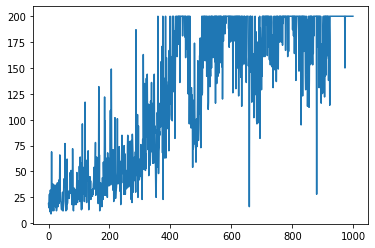

In [0]:
plt.plot(epi_rewards)
plt.show()

In [0]:
import glob
import base64
import io
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
        
show_video()